# Exploratory Analysis

1. High Energy Groceres during Colder Months
2. Sweeter Foods w/ Product Ratings
3. Non-Verified Reviews
4. Review Time and Rating: Day of Week vs. Produt Rating
5. Helpful vs. Not Helpful Reviews: Sentence Generation
6. Nutrients vs. Time 
    
TODO:
+ Can review headline indicate good rating?
  + using the few words in headline, indicate a good rating?
+ Helpful reviews length
+ Helpeful votes with Nutrients/Categories?
  + maybe some products require more helpful votes?
+ model helpful reviews by review words...etc
  + since helpful reviews are likel to influence other users
+ helpful reivews
  + would some categories have more helpful reviews?
  + would some nutrients product have more helpful reviews?

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
import os
from sqlalchemy import create_engine

from dotenv import load_dotenv # env variables
load_dotenv(verbose=True)

True

In [4]:
SQLALCHEMY_DATABASE_URI = os.getenv('DATABASE_URL')
engine = create_engine(SQLALCHEMY_DATABASE_URI)

use merged data from file
```python
data_path = 'D:\DATA\OurFoods'
df = pd.read_csv(os.path.join(data_path, 'merged_amz-off_3.csv.gz'),\
                 dtype={'customer_id': 'object', 'product_parent': 'object', \
                        'star_rating': pd.Int64Dtype(), 'helpful_votes': pd.Int64Dtype(), 
                        'total_votes': pd.Int64Dtype(), \
                        'code': 'object'},
                 compression='gzip')
# convert reivew_date to datetime object
df.review_date = pd.to_datetime(df.review_date)
df.shape
```

### 1. Higher Energy Groceries at Colder Months
+ group by each month, calculate mena energy value
+ group by each month, shown energy with scatterplot or boxplot

In [4]:
from calendar import month_name

In [5]:
sql = \
"""
SELECT 
    review_date, 
    energy_100g, fat_100g, fiber_100g, 
    carbohydrates_100g, proteins_100g, 
    salt_100g, sodium_100g, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
"""
df = pd.read_sql(sql, con=engine)
df.shape

(137698, 9)

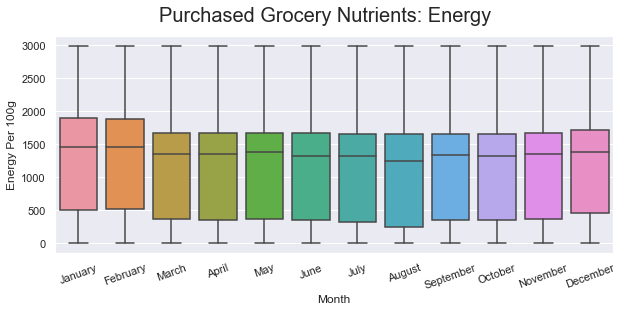

In [6]:
# shown with boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df.review_date.dt.month, y=df.energy_100g)

plt.xlabel('Month')
plt.xticks(range(12), month_name[1:13], rotation=20)
plt.ylabel('Energy Per 100g')
plt.suptitle('Purchased Grocery Nutrients: Energy', fontsize=20)

# plt.savefig('./figures/nutrients-energy.png', bbox_inches='tight', dpi=300)
plt.show()
# boxes are higher at 1, 2, and 12
# with non_verified reviews

### 2. Sweeter Foods with Product Ratings

In [7]:
sql = \
"""
SELECT 
    review_id, review_date, star_rating, 
    energy_100g, fat_100g, fiber_100g, 
    carbohydrates_100g, proteins_100g, 
    salt_100g, sodium_100g, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)
df.shape

(115341, 11)

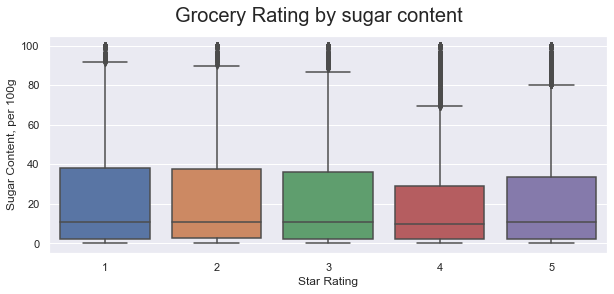

In [8]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='star_rating', y='sugars_100g', data=df)

plt.xlabel('Star Rating')
plt.ylabel('Sugar Content, per 100g')
plt.suptitle('Grocery Rating by sugar content', fontsize=20)
# plt.savefig('./figures/sugar.png', bbox_inches='tight', dpi=300)
plt.show()

### 3. What are the Non-Verified reviews?

In [9]:
sql = \
"""
SELECT 
    review_id, review_date, star_rating, 
    verified_purchase, main_category_en,
    energy_100g, fat_100g, fiber_100g, 
    carbohydrates_100g, proteins_100g, 
    salt_100g, sodium_100g, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
"""
df = pd.read_sql(sql, con=engine)
df.shape

(137698, 13)

In [10]:
df.verified_purchase.value_counts()

Y    115341
N     22357
Name: verified_purchase, dtype: int64

In [11]:
df[df.verified_purchase == 'N'].main_category_en.value_counts().head(10)
# most are at beverages and spreads

Beverages                          3213
Spreads                            2175
Snacks                             1882
Plant-based foods and beverages    1526
Groceries                           902
Meats                               288
fr:the-vert-aromatise               171
Dairies                             139
Fruit juices                         98
Cooking helpers                      88
Name: main_category_en, dtype: int64

## 4. Review Time and Product Rating
+ day of week vs. product rating

In [39]:
sql = \
"""
SELECT 
    review_date, star_rating
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)
df.shape

(115341, 3)

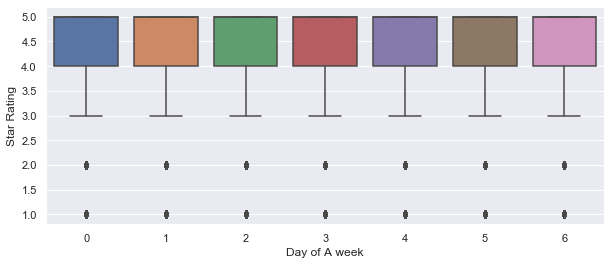

In [45]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df.review_date.dt.dayofweek, y=df.star_rating)

plt.xlabel('Day of A week')
plt.ylabel('Star Rating')
plt.show()
# no significant difference

### 5. Helpful vs. Not Helpful Reviews
+ What are helpful and non-helpful review saying?
+ Using Trigram model for sentence generations
+ Choose different start word to generate

In [12]:
import re
import json
import operator
# import pprint
from nltk.util import ngrams
from collections import Counter

In [13]:
sql = \
"""
SELECT 
    review_id, 
    helpful_votes, total_votes,
    review_headline, review_body
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
    AND total_votes > 0
"""
# assume helpful_votes / total_votes > .5 is a helpful review
df = pd.read_sql(sql, con=engine)\
    .assign(helpful=lambda df: df.helpful_votes/df.total_votes >= .5)
df.shape

(44363, 6)

In [14]:
# given a review string, return list of list of tokens
def reviewTokenize(review):
    # remove line breaker, non-word, except space and period,
    review =  re.sub(r'<br />|[^A-Za-z. ]', '', review.lower())
    # remove space at setence end
    review =  re.sub(r'\s$', '', review)
    # reduce multiple space to single
    review = re.sub(' +', ' ', review) 
    # split by end of sentence 
    sents = review.split('.')
    # split into tokens, ignore empty string
    return [[token for token in sent.split(' ') if token != ''] \
            for sent in sents if sent != '' ] 

In [15]:
# using dict, then convert to Counter
def build_trigrams(review_bodys):
    model = {}
    for review in review_bodys:
        for sent in reviewTokenize(review):
            trigrams = ngrams(sent, 3, pad_left=True, pad_right=True, \
                             left_pad_symbol='<s>', right_pad_symbol='</s>')
            for trigram in trigrams:
                if model.get(trigram) is not None:
                    model[trigram] += 1
                else:
                    model[trigram] = 1
    return model

In [16]:
# turn the result into dict 
def trigram_to_dict(trigrams):
    d = {}
    for words, p in trigrams: 
        w1, w2, w3 = words
        if d.get(w1) is not None:
            if d[w1].get(w2) is not None:
                d[w1][w2][w3] = p
            else:
                d[w1][w2] = {w3: p}
        else:
            d[w1] = {w2: {w3: p}}
    return d
# pprint.pprint(d)

### Helpful Reviews

In [17]:
modelHelpful = build_trigrams(df[df.helpful == True].review_body)
freqHelpful = [(k, v / len(modelHelpful) * 100.0) for k, v in modelHelpful.items()]
helpful = trigram_to_dict(freqHelpful)

In [18]:
textLen = 10
sentence = ['<s>', '<s>']
while len(sentence) < textLen:
    w1, w2 = sentence[-2:]
    if (w1 == '</s>') & (w2 == '</s>'): 
        break
    next_word = max(helpful[w1][w2].items(), key=operator.itemgetter(1))[0]
    sentence.append(next_word)
sentence

['<s>', '<s>', 'i', 'have', 'been', 'using', 'this', 'product', '</s>', '</s>']

### Non-helpful Reviews

In [19]:
mdlNotHelpful = build_trigrams(df[df.helpful == False].review_body)
freqNotHelpful = [(k, v / len(mdlNotHelpful) * 100.0) for k, v in mdlNotHelpful.items()]
notHelpful = trigram_to_dict(freqNotHelpful)

In [20]:
textLen = 20
sentence = ['<s>', '<s>']
while len(sentence) < textLen:
    w1, w2 = sentence[-2:]
    if (w1 == '</s>') & (w2 == '</s>'): 
        break
    next_word = max(notHelpful[w1][w2].items(), key=operator.itemgetter(1))[0]
    sentence.append(next_word)
' '.join(sentence)

'<s> <s> i have to say i am not a good price </s> </s>'

### Export both dict

In [21]:
# reduce frequency dict size
def reduce_dictSize(freqDict, size=5, startingSize=30): 
    for w1 in freqDict.keys():
        for w2 in freqDict[w1].keys():
            # if sentence starting tokens
            if (w1 == '<s>') & (w2 == '<s>'): 
                tmp = dict(sorted(freqDict[w1][w2].items(), \
                                  key=lambda kv: kv[1], reverse=True)[:startingSize])
            # if other tokens
            else: 
                tmp = dict(sorted(freqDict[w1][w2].items(), \
                                  key=lambda kv: kv[1], reverse=True)[:size])
            freqDict[w1][w2] = tmp
    return freqDict

In [22]:
d = {'helpful': reduce_dictSize(helpful, 3, 10), \
     'notHelpful': reduce_dictSize(notHelpful, 3, 10) }

In [23]:
# with open('helpful_reviews.json', 'w', encoding='utf-8') as f:
#     json.dump(d, f, ensure_ascii=False, indent=4)

In [24]:
len(d['helpful']), len(d['notHelpful'])

(33921, 14493)

In [84]:
def recursion(sent, sents, trigrams):
    w1, w2 = sent[-2:]
     # terminate condition: end of sentence or sentence length
    if (w1 == '</s>') | (w2 == '</s>'): 
        sents.append(sent[1:])
        return sents
    if len(sent) >= 12: # limit setence length
        return sents
    
    # iterate each word on subset 
    for word in trigrams[w1][w2].keys():
        sents = recursion(sent+[word], sents, trigrams)
    return sents

In [86]:
# build sentences to visualization
helpfulSents = recursion(['<s>', '<s>', 'i'], [], helpful)
notHelpfulSents = recursion(['<s>', '<s>', 'i'], [], notHelpful)
len(helpfulSents), len(notHelpfulSents)

(1601, 1352)

In [ ]:
for sent in hel

In [85]:
v = {'helpful': helpfulSents, 
    'notHelpful': notHelpfulSents}
with open('helpful_sents.json', 'w', encoding='utf-8') as f:
    json.dump(v, f, ensure_ascii=False, indent=4)

## 6. Nutrients vs. Time
+ plot not meaningful, showing no time difference in values
+ not shown

In [63]:
nutrients = [
    'energy_100g', 'fat_100g', 'fiber_100g', 
    'carbohydrates_100g', 'proteins_100g', 
    'salt_100g', 'sodium_100g', 'sugars_100g'
]

In [5]:
start_date = '2014-01-01'
end_date = '2014-12-31'

In [25]:
sql = \
"""
SELECT 
    review_date,
    energy_100g, fat_100g, fiber_100g, 
    carbohydrates_100g, proteins_100g, 
    salt_100g, sodium_100g, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date BETWEEN '{0}' AND '{1}'
ORDER BY
    review_date
""".format(start_date, end_date)
df = pd.read_sql(sql, con=engine)
df.shape

(44152, 9)

In [51]:
dateIdx = []
for nutri in nutrients:
    for date in pd.date_range(start_date, end_date, freq='D'):
        dateIdx.append((nutri, date))
len(dateIdx) # (number of nutrients) * (number of days)

2920

In [52]:
# data preparation
data = df.fillna(0)\
    .melt(id_vars='review_date', value_vars=nutrients)\
    .groupby(['variable', 'review_date']).agg('mean')\
    .reindex(dateIdx, fill_value=0)\
    .reset_index()

In [53]:
# calculate p
data = data\
    .assign(nutrientSum=lambda d: d.groupby('variable')[['value']].transform('sum'))\
    .assign(p=lambda d: d.value / d.nutrientSum)

In [56]:
# calculate max p
data = data\
    .assign(nutrientMaxP=lambda d: d.groupby('variable')[['p']].transform(max))\
    .assign(p_peak=lambda d: d.p / d.nutrientMaxP)

In [57]:
# calculate smoothed p, 3 days smoothing
data = data\
    .assign(p_lag1=lambda d: d.groupby('variable')[['p_peak']].shift(-1))\
    .assign(p_lead1=lambda d: d.groupby('variable')[['p_peak']].shift(1))\
    .assign(p_smooth=lambda d: (d.p_lag1 + d.p_peak + d.p_lead1) / 3)

```python
# add p smooth attribute, w/ 7 days smoothing
data = data\
    .assign(p_lag1=lambda d: d.groupby('variable')[['p_peak']].shift(-1))\
    .assign(p_lag2=lambda d: d.groupby('variable')[['p_peak']].shift(-2))\
    .assign(p_lag3=lambda d: d.groupby('variable')[['p_peak']].shift(-3))\
    .assign(p_lead1=lambda d: d.groupby('variable')[['p_peak']].shift(1))\
    .assign(p_lead2=lambda d: d.groupby('variable')[['p_peak']].shift(2))\
    .assign(p_lead3=lambda d: d.groupby('variable')[['p_peak']].shift(3))\
    .assign(p_smooth7=lambda d: (d.p_lag1 + d.p_lag2 + d.p_lag3 + 
                                 d.p_lead1 + d.p_lead2 + d.p_lead3 +
                                 d.p_peak) / 7)\
    .drop(['p_lag1', 'p_lag2', 'p_lag3', 'p_lead1', 'p_lead2', 'p_lead3'], axis=1)\
    .fillna(method='ffill', axis=1)
data.shape
```

In [59]:
# clean up data
data = data\
    .drop(['value', 'nutrientSum', 'nutrientMaxP', 'p_lag1', 'p_lead1',], axis=1)\
    .rename(columns={'variable': 'nutrient', 'review_date': 'date'})\
    .fillna(method='ffill', axis=1)

In [62]:
# sample for first 3 rows
data.iloc[:3, :].to_json(orient='records')
# data.to_json('local.json', orient='records', )

'[{"nutrients":"energy_100g","date":1388534400000,"p":0.0026463286,"p_peak":0.7692830057,"p_smooth":0.7692830057},{"nutrients":"energy_100g","date":1388620800000,"p":0.0029755228,"p_peak":0.8649791847,"p_smooth":0.7959088311},{"nutrients":"energy_100g","date":1388707200000,"p":0.0025919123,"p_peak":0.753464303,"p_smooth":0.8461413041}]'

## 7. Categories vs. Time
+ ridgeline plot

In [64]:
start_date = '2014-01-01'
end_date = '2014-12-31'

In [65]:
query = \
"""
SELECT 
    main_category_en AS category, 
    review_date, 
    review_id AS id
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND review_date IS NOT NULL
    AND main_category_en IS NOT NULL
    AND energy_100g < 3000
    AND salt_100g < 100
    AND main_category_en SIMILAR TO '[A-Z]_*'
    AND review_date BETWEEN '{0}' AND '{1}'
ORDER BY
    review_date
""".format(start_date, end_date)
df = pd.read_sql(query, con=engine)

In [66]:
# get top 10 threshold
threshold = df.groupby('category')[['id']].count()\
    .sort_values('id', ascending=False)\
    .iloc[9, 0] # get 10th category count
threshold

233

In [82]:
# Sice by TOP10 threshold
top10 = df.assign(counts=lambda d: d.groupby('category')[['id']].transform('count'))\
        .query('counts >= {}'.format(threshold))\
        .replace({'Plant-based foods and beverages': 'Plant-Based', 
                  'Products without gluten': 'No Gluten',
                  'Coffee-creamer': 'Creamer'})\
        .reset_index(drop=True)
top10.shape

(16048, 4)

In [83]:
top10.category.unique()

array(['Beverages', 'Plant-Based', 'Groceries', 'Snacks', 'Spreads',
       'Meats', 'Dairies', 'Creamer', 'No Gluten', 'Sweeteners'],
      dtype=object)

### Date Range index
+ Not Every Category has data for every date in the range
+ Supplement with 0 value 
+ Use Date Index

In [69]:
date_idx = []
for category in top10.category.unique():
    for date in pd.date_range(start_date, end_date, freq='D'):
        date_idx.append((category, date))
len(date_idx) # (number of category) * (number of days)

3650

### Plotting Values

In [70]:
# add p attribute
data = top10.groupby(['category', 'review_date'])[['id']].count()\
    .reindex(date_idx, fill_value=0)\
    .reset_index()\
    .assign(byCategorySum=lambda d: d.groupby('category')[['id']].transform('sum'))\
    .assign(p=lambda d: d.id / d.byCategorySum)\
    .drop(['id', 'byCategorySum'], axis=1)
data.shape

(3650, 3)

In [71]:
# add p peak attribute
data = data.assign(byCategoryMaxP=lambda d: d.groupby('category')[['p']].transform(max))\
    .assign(p_peak=lambda d: d.p / d.byCategoryMaxP)\
    .drop(['byCategoryMaxP'], axis=1)
data.shape

(3650, 4)

In [72]:
# add p smooth attribute
data = data.assign(p_lag1=lambda d: d.groupby('category')[['p_peak']].shift(-1))\
    .assign(p_lead1=lambda d: d.groupby('category')[['p_peak']].shift(1))\
    .assign(p_smooth=lambda d: (d.p_lag1 + d.p_peak + d.p_lead1) / 3)\
    .drop(['p_lag1', 'p_lead1'], axis=1)\
    .fillna(method='ffill', axis=1)
data.shape

(3650, 5)

In [73]:
# add p smooth attribute, w/ 7 days smoothing
data = data\
    .assign(p_lag1=lambda d: d.groupby('category')[['p_peak']].shift(-1))\
    .assign(p_lag2=lambda d: d.groupby('category')[['p_peak']].shift(-2))\
    .assign(p_lag3=lambda d: d.groupby('category')[['p_peak']].shift(-3))\
    .assign(p_lead1=lambda d: d.groupby('category')[['p_peak']].shift(1))\
    .assign(p_lead2=lambda d: d.groupby('category')[['p_peak']].shift(2))\
    .assign(p_lead3=lambda d: d.groupby('category')[['p_peak']].shift(3))\
    .assign(p_smooth7=lambda d: (d.p_lag1 + d.p_lag2 + d.p_lag3 + 
                                 d.p_lead1 + d.p_lead2 + d.p_lead3 +
                                 d.p_peak) / 7)\
    .drop(['p_lag1', 'p_lag2', 'p_lag3', 'p_lead1', 'p_lead2', 'p_lead3'], axis=1)\
    .fillna(method='ffill', axis=1)
data.shape

(3650, 6)

In [74]:
# export to json, as records
# [{category: ..., review_date: ..., p: ..., p_peak: ..., p_smooth: ...}, {}, {}, ...]
data.iloc[:3, :].to_json(orient='records')

'[{"category":"Beverages","review_date":1388534400000,"p":0.0016230002,"p_peak":0.2121212121,"p_smooth":0.2121212121,"p_smooth7":0.2121212121},{"category":"Beverages","review_date":1388620800000,"p":0.0016230002,"p_peak":0.2121212121,"p_smooth":0.2424242424,"p_smooth7":0.2424242424},{"category":"Beverages","review_date":1388707200000,"p":0.0023185718,"p_peak":0.303030303,"p_smooth":0.2222222222,"p_smooth7":0.2222222222}]'